In [127]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import window_detect as w

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

import sys
sys.path.insert(0, "../scripts")
import helpers as h

## Pull Data

In [94]:
file_types = {
            "temp": f"NatSciData_E{room_num}Tair.csv",
            "bw": f"NatSciData_E{room_num}W.csv", # bottom window 
            "tw": f"NatSciData_E{room_num}WT.csv", # top window
            "occ": f"NatSciData_E{room_num}Occ.csv"
        }


def pull_and_filter_data(type, room_num="01", month="06", num_days=4, all_data=False, file_types=file_types):
    path = f"../../data/ext_data/schweiker 2019/{file_types[type]}"
    # print(path)
    df =  pd.read_csv(path)

    # convert datetime column to correct format 
    df.loc[:, "DateTime"] = pd.to_datetime(df["DateTime"])

    start = pd.to_datetime(f"2005-{month}-01 08:00")
    end = pd.to_datetime(f"2005-{month}-{1+num_days} 08:00")
    mask = (df['DateTime'] >= start) & (df['DateTime'] <= end)
    df_lim = df.loc[mask].reset_index(drop=True)

    if all_data: 
        return df
    else:
        return df_lim 
    

    

In [76]:
def pull_all_data_types(room_num="01", month="06", num_days=4, all_data=False):
    d = {}
    for type in file_types.keys():
            d[type] = pull_and_filter_data(type, room_num, month, num_days, all_data)
    return d

In [92]:
def plot_all_data_types(d):
    fig = go.Figure()

    # plot temp 
    fig.add_trace(go.Scatter(
    x=d["temp"]["DateTime"],
    y=h.normalize(d["temp"].iloc[:,1]), 
    mode='markers+lines',
    name="air temp"))

    ft_keys =  list(file_types.keys())
    ft_keys.remove("temp")

    for type in ft_keys:
        fig.add_trace(go.Scatter(
            x=d[type]["DateTime"],
            y=d[type].iloc[:,1], 
            mode='markers',
            name=type
            ))

    return fig



## Compare Data

In [95]:
e01_sep10 = pull_all_data_types(room_num="01", month="09", num_days=10)
plot_all_data_types(e01_sep10)

In [100]:
e01_june10 = pull_all_data_types(room_num="01", month="06", num_days=10)
plot_all_data_types(e01_june10)

In [142]:
e01_june10["tw"]

,DateTime,E01WT
0,2005-06-03 05:01:10,1
1,2005-06-03 05:04:30,0
2,2005-06-04 05:01:10,1
3,2005-06-04 05:04:30,0
4,2005-06-05 05:01:10,1
5,2005-06-05 05:04:40,0
6,2005-06-05 21:01:30,1
7,2005-06-05 21:58:20,0
8,2005-06-06 05:01:10,1
9,2005-06-06 05:10:30,0


## Testing out STL method

In [113]:
df = e01_june10["temp"]
df.rename(columns={ "E01Tair": "Temp C"}, inplace=True)

In [130]:
obs_deriv = h.normalize(pd.Series(np.gradient(df["Temp C"]), df["DateTime"], name='obs_deriv'))

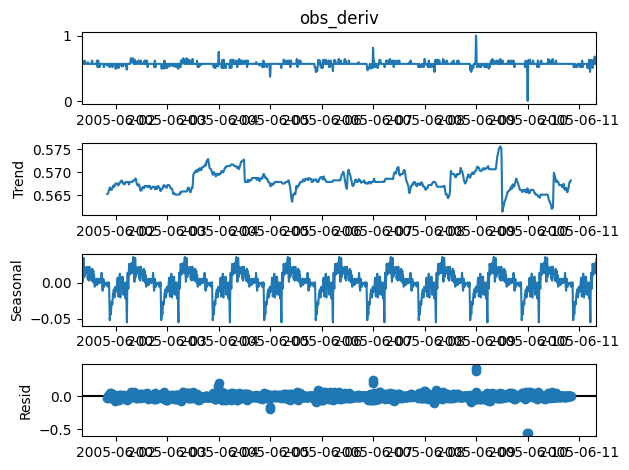

In [161]:
n_samples = 6 # TODO: make this a function of the period
seasonality_period = 24
period = n_samples*seasonality_period
stl_deriv = seasonal_decompose(obs_deriv,model='additive', period=period)
stl_deriv.plot();

In [165]:
stl_deriv_dif = h.normalize(h.normalize(stl_deriv.seasonal) - obs_deriv)

stl_deriv_dif_deriv = h.normalize(pd.Series(np.gradient(stl_deriv_dif), stl_deriv_dif.index, name='deriv'))

In [166]:
fig = go.Figure()

fig.add_trace(go.Scatter(
            x=e01_june10["tw"]["DateTime"],
            y=e01_june10["tw"].iloc[:,1], 
            mode='markers',
            name="top window change"
            ))

fig.add_trace(go.Scatter(
                    x=df["DateTime"],
                    y=h.normalize(df["Temp C"]), 
                    mode='lines',
                    name="Variable Open Obs"
                ))

# derivative of observation only 
fig.add_trace(go.Scatter(
                    x=obs_deriv.index,
                    y=obs_deriv, 
                    mode='lines',
                    name="Obs 1st Deriv "
                ))


fig.add_trace(go.Scatter(
                    x=stl_deriv.seasonal.index,
                    y=h.normalize(stl_deriv.seasonal), 
                    mode='lines',
                    name="STL of Obs Deriv "
                ))

# difference between this stl decomp 
fig.add_trace(go.Scatter(
                    x=stl_deriv_dif.index,
                    y=stl_deriv_dif, 
                    mode='lines',
                    name="STL of Obs Deriv - Obs Deriv "
                ))

fig.add_trace(go.Scatter(
            x=e01_june10["occ"]["DateTime"],
            y=e01_june10["occ"].iloc[:,1], 
            mode='markers',
            name="occupant"
            ))

# # s3d
fig.add_trace(go.Scatter(
                    x=stl_deriv_dif_deriv.index,
                    y=stl_deriv_dif_deriv, 
                    mode='lines',
                    name="Deriv of Obs STL Dif  Deriv "
                ))

In [129]:
wd = w.Window_Detect(exp="A", period="10T")

wd.determine_varied_room()


,DateTime,Temp C,RH %,Room,Ambient Temp,Ambient RH,Window Open
2022-07-20 07:15:00,2022-07-20 07:15:00,23.4386,52.936100,1.0,14.333333,30.555556,0.0
2022-07-20 07:30:00,2022-07-20 07:30:00,23.4178,52.758200,1.0,14.333333,30.555556,0.0
2022-07-20 07:45:00,2022-07-20 07:45:00,23.4154,52.931800,1.0,14.333333,30.555556,1.0
2022-07-20 08:00:00,2022-07-20 08:00:00,23.5538,52.837900,1.0,14.666667,30.555556,1.0
2022-07-20 08:15:00,2022-07-20 08:15:00,23.6650,52.722367,1.0,14.666667,30.555556,1.0
...,...,...,...,...,...,...,...
2022-07-24 06:15:00,2022-07-24 06:15:00,23.3738,52.782333,1.0,14.611111,30.555556,0.0
2022-07-24 06:30:00,2022-07-24 06:30:00,23.3722,52.877567,1.0,14.611111,30.555556,0.0
2022-07-24 06:45:00,2022-07-24 06:45:00,23.3578,53.006400,1.0,14.611111,30.555556,0.0
2022-07-24 07:00:00,2022-07-24 07:00:00,23.3578,53.126733,1.0,14.722222,30.555556,0.0


KeyError: 'Window Open'

## Distributions of Occupant Data

In [ ]:
e01_bw, _ = pull_and_filter_data("bw",)
e01_tw, _ = pull_and_filter_data("tw")
e01_occ, _ = pull_and_filter_data("occ")
e01_temp, _ = pull_and_filter_data("temp")

<AxesSubplot:xlabel='DateTime,DateTime'>

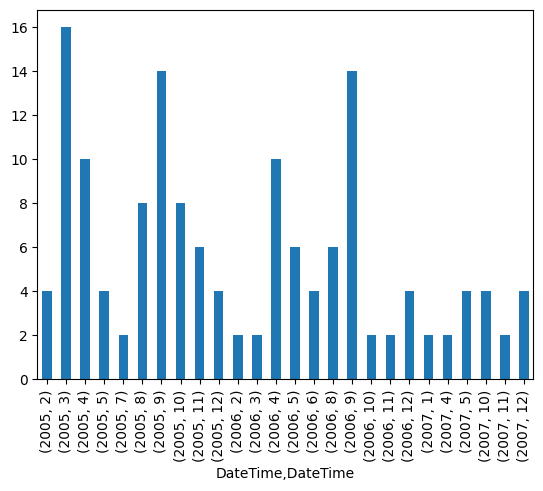

In [55]:
e01_bw["DateTime"].groupby([e01_bw["DateTime"].dt.year, e01_bw["DateTime"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='DateTime,DateTime'>

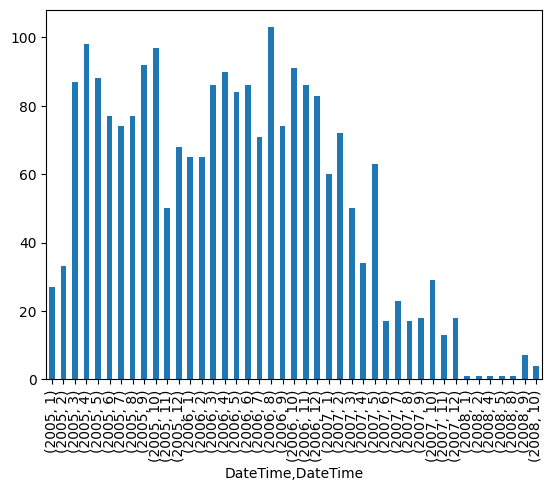

In [58]:
e01_tw["DateTime"].groupby([e01_tw["DateTime"].dt.year, e01_tw["DateTime"].dt.month]).count().plot(kind="bar")

<AxesSubplot:xlabel='DateTime,DateTime'>

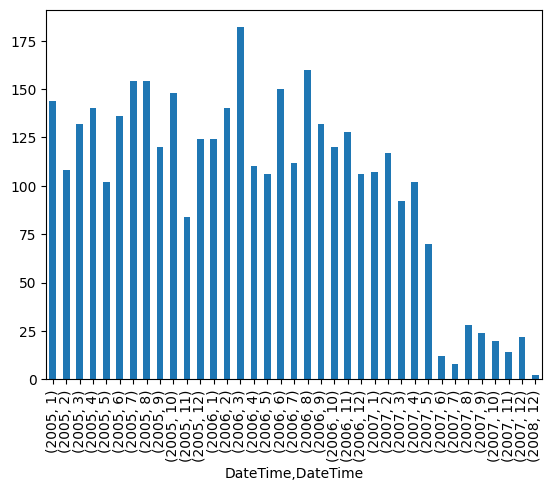

In [54]:
occ_hist = e01_occ["DateTime"].groupby([e01_occ["DateTime"].dt.year, e01_occ["DateTime"].dt.month]).count().plot(kind="bar")